# Uproot I/O and Awkard Arrays

## Introduction

Scikit-HEP is a community-driven project that provides a comprehensive software ecosystem for high energy physics (HEP) analysis in Python. Its goal is to standardize and streamline data analysis workflows in HEP by offering a coherent collection of libraries that integrate with widely used tools such as Numpy, Pandas, Matplotlib, and Scikit-Learn. Among its major packages are:

  * Uproot: For reading and writing ROOT files without requiring ROOT.
  * Awkward Arrays: For the handling of jagged data structures.
  * Hist: For creating and manipulating histograms.
  * Vector: For manipulating and operating on vectors of different kinds in a high-performance manner.
  * Boost-Histogram: For fast, multi-dimensional histogramming.
  * Particle: For handling particle physics data, including properties and PDG codes.
  * Iminuit: For fitting.

In this tutorial, you will be introduced to the main components of the Scikit-HEP project, starting with Uproot and building from there. For more information on the Scikit-HEP project and the tools it offers, please visit the official [Scikit-HEP Project Website](https://scikit-hep.org/).

## ROOT Files

ROOT files are a specialized binary file format developed for the efficient storage and analysis of large-scale data in high energy physics (HEP). They are structured hierarchically, much like a miniature filesystem, allowing for the organization of data into nested directories and subdirectories. Within these directories, ROOT files can store a wide variety of data types, including TTrees (which are analogous to tables or dataframes and are optimized for fast access to large datasets), histograms, graphs, and even user-defined objects. This flexible structure makes ROOT files particularly well-suited for complex experimental data, where different types of information (e.g., event records, calibration constants, and analysis results) need to be stored together in a single, organized file.

An example ROOT file structure can be seen in {numref}`roottree`.

```{figure} ./assets/roottree.png
---
height: 350px
name: roottree
---
ROOT file structure example.
```

Let's look a bit more closely at what each part of this example ROOT file are.

- TDirectorys are container objects that act like a directory in a filesystem. I can hold other objects such as histograms, TTrees, or even other TDirectories.
- TTrees are a high-performance data structure designed with storing large tabular datasets in ROOT files. It is conceptually similar to a table or a DataFrame, where each row (i.e., "entry" or "event") represents a single data record, and each column (i.e., "branch") holds a specific variable or array of variables.
- TBranches corresponds to a column in a TTree. Each contains data for a specific variable or set of variables. They can store simple types (like numbers) or complex objects (like arrays or custom classes).
- A TBasket is a chunck or block of data in a TBranch. They allow for more efficient access to parts of the data without having to load the entire branch into memory.

## Uproot

Uproot allows us to read and write ROOT files. It interacts with Numpy, Pandas as well as the packages offered by Scikit-HEP. It was created to not have to use ROOT in order to quickly work with ROOT files, which can be slow to load.

## Opening a File

To move forward, run the following cells to import `Uproot` and to download the sample data. This data is part of the `skhep_testdata` package which is another Scikit-HEP package which provides example files for testing and development.

In [76]:
# Run this cell to import Uproot
import uproot
import skhep_testdata

# Downloads test file and returns path to it
filename = skhep_testdata.data_path("uproot-Event.root")
file = uproot.open(filename)
file

<ReadOnlyDirectory '/' at 0x00011e99d090>

This file object actually represents a directory and its contents are accesible through a dict-like interface. Let's see what keys is has available.

In [77]:
file.items()

[('ProcessID0;1', <TProcessID (version 1) at 0x00011e99d310>),
 ('htime;1', <TH1F (version 2) at 0x00011e829e00>),
 ('T;1', <TTree 'T' (1 branches) at 0x00011e99d450>),
 ('hstat;1', <TH1F (version 2) at 0x00011dfe3bf0>)]

We can see tha it contains multiple values, each of different type. The types seen here are:

  - `TProcessID`: 
    - ROOT class that keeps track of process IDs in ROOT files. It is used internally by ROOT to manage object and their references, ensuring that object have unique identifiers across files or sessions. Typically useful for analysis.
  - `TH1F`: 
    - One-dimensional histogram with floating-point bin contents.
  - `TTree`: 
    - ROOT class used for efficient storage and access of large datasets. 
    - Can be conceptualized as a table in a database of a DataFrame in pandas, where each column (branch) can contian different types of data, and each row (entry) corresponds toa single event or datapoint.
    - If it too large to fit in memory a TBranch can be broken down in to TBaskets which are batches of data. They are the smallest unit to read from a TTree.

We can easily read the histograms and utilize useful method provided by Uproot to convert the data to something more friendly, like NumPy or Awkawrd arrays (more on that later). For instance, if we want to do the former, we can access the histogram using the dict-like interphase you should already be familiar with:

### Reading the histogram

In [78]:
h = file["hstat;1"]
h

<TH1F (version 2) at 0x00011dfe3bf0>

That doesn't look like a histogram! If we want to visualize it, we can use the `to_hist` method. The output of this method is an object of type `hist.Hist` which is visualized in a Jupyter Notebook in a simplified way if just displayed directly (we will discuss the `hist` library in more detail later!).

In [79]:
h.to_hist()

Hist(Regular(100, 0, 1, name='xaxis'), storage=Double()) # Sum: 1000.0

If we want to properly plot this histogram and be able to modify how it looks, we can use the `plot` method of the `hist.Hist` object. This method uses `matplotlib` to make a nice looking plot which we can then modify in any way we wish.

/Users/roycruz/Local/PythonHEP/venv/lib/python3.13/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x11ecb4910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

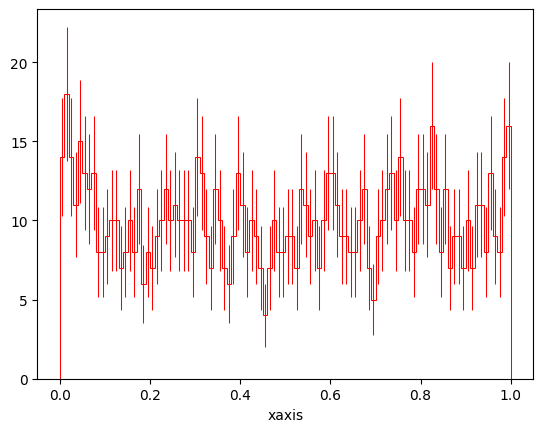

In [80]:
# Using the hist Scikit-HEP library (more on that later...)
h.to_hist().plot(linewidth=0.75, color="red")

We can also convert the histogram to NumPy objects by using the `to_numpy` method. This method gives us a tuple. The first element is an array with the height of each bin, and the second element is an array with the edges of the histogram bins.

In [81]:
# Converting the histogram object to numpy arrays
h.to_numpy()
# First array is the data, second one is for bins

(array([14., 18., 14., 11., 15., 13., 12., 13.,  8.,  8.,  9., 10., 10.,
         7.,  8., 10.,  8., 12.,  6.,  8.,  7.,  9., 10., 12., 10., 11.,
        10., 10., 10.,  8., 14., 13.,  9.,  7., 12., 10.,  7.,  6.,  9.,
        13., 11.,  8., 10.,  9.,  7.,  4.,  7., 10.,  8.,  8.,  9.,  9.,
         7., 12., 11.,  9., 10.,  7., 10., 13., 13., 11.,  9.,  9.,  8.,
         8., 10., 12.,  7.,  5.,  9., 10., 12., 13., 10., 14., 10., 10.,
         8., 12., 12., 11., 16., 12.,  8., 12.,  7.,  9.,  9.,  7., 10.,
         7., 11., 11.,  8., 13.,  9.,  8., 14., 16.], dtype=float32),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61,

We can also use these arrays to make a plot of this histogram manually with matplotlib.

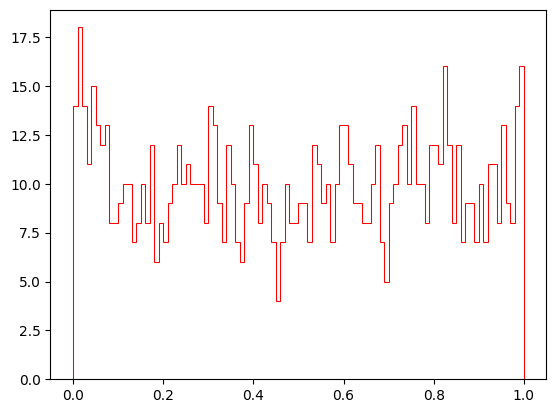

In [82]:
# We can then use plot this data using matplotlib
import matplotlib.pyplot as plt
hist_data, bin_edges = h.to_numpy()
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.hist(bin_edges[:-1], bin_edges, weights=hist_data, histtype="step", color="red", linewidth=0.75)
plt.show()

The `hist.Hist` object also lets us directly accessthe values, errors and bin edges.

In [83]:
print(h.values())

[14. 18. 14. 11. 15. 13. 12. 13.  8.  8.  9. 10. 10.  7.  8. 10.  8. 12.
  6.  8.  7.  9. 10. 12. 10. 11. 10. 10. 10.  8. 14. 13.  9.  7. 12. 10.
  7.  6.  9. 13. 11.  8. 10.  9.  7.  4.  7. 10.  8.  8.  9.  9.  7. 12.
 11.  9. 10.  7. 10. 13. 13. 11.  9.  9.  8.  8. 10. 12.  7.  5.  9. 10.
 12. 13. 10. 14. 10. 10.  8. 12. 12. 11. 16. 12.  8. 12.  7.  9.  9.  7.
 10.  7. 11. 11.  8. 13.  9.  8. 14. 16.]


In [84]:
print(h.errors())

[3.74165739 4.24264069 3.74165739 3.31662479 3.87298335 3.60555128
 3.46410162 3.60555128 2.82842712 2.82842712 3.         3.16227766
 3.16227766 2.64575131 2.82842712 3.16227766 2.82842712 3.46410162
 2.44948974 2.82842712 2.64575131 3.         3.16227766 3.46410162
 3.16227766 3.31662479 3.16227766 3.16227766 3.16227766 2.82842712
 3.74165739 3.60555128 3.         2.64575131 3.46410162 3.16227766
 2.64575131 2.44948974 3.         3.60555128 3.31662479 2.82842712
 3.16227766 3.         2.64575131 2.         2.64575131 3.16227766
 2.82842712 2.82842712 3.         3.         2.64575131 3.46410162
 3.31662479 3.         3.16227766 2.64575131 3.16227766 3.60555128
 3.60555128 3.31662479 3.         3.         2.82842712 2.82842712
 3.16227766 3.46410162 2.64575131 2.23606798 3.         3.16227766
 3.46410162 3.60555128 3.16227766 3.74165739 3.16227766 3.16227766
 2.82842712 3.46410162 3.46410162 3.31662479 4.         3.46410162
 2.82842712 3.46410162 2.64575131 3.         3.         2.6457

In [85]:
print(h.axis("x").edges())

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


### Accesing the TTree

The TTree present in this example file contains simulated collisions data. To get us started, lets read the data using the dict-like interphase.

In [86]:
t = file["T;1"]
t

<TTree 'T' (1 branches) at 0x00011e99d450>

As you can see, directly printing `t` is not very useful and does not gives us much insight into the actual contents of the TTree. In order to get a glimpse of the data, it conveniently has a method called `show` which gives you a list of the name of each branch, as well as the type of data that is contained in each branch.

In [87]:
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | Event                    | AsGroup(<TBranchElement 'ev...
event/TObject        | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
event/TObject/fUn... | uint32_t                 | AsDtype('>u4')
event/TObject/fBits  | uint32_t                 | AsDtype('>u4')
event/fType[20]      | int8_t[20]               | AsDtype("('i1', (20,))")
event/fEventName     | char*                    | AsStrings(length_bytes='4')
event/fNtrack        | int32_t                  | AsDtype('>i4')
event/fNseg          | int32_t                  | AsDtype('>i4')
event/fNvertex       | uint32_t                 | AsDtype('>u4')
event/fFlag          | uint32_t                 | AsDtype('>u4')
event/fTemperature   | float                    | AsDtype('>f4', 'float64')
event/fMeasures[10]  | int32_t[10]              | AsDtype

If the large output from the `show` method is not to your liking, you can also use the `keys` method (more dict-like interphase!) to just get a list of the names of each field. Then, once you identify the one you are interested in, you can do the following to get more information on that particular branch.

In [88]:
# Other ways to get the same information
print(t["event/fNtrack"].typename)
print(t["event/fNtrack"].interpretation)

int32_t
AsDtype('>i4')


Suppose you already know the exact branch you want to access, and you just want to work with the data. To do that, you need to use the `array` method for a particular branch, which will return a special type of array.

In [89]:
t["event/fNtrack"].array()

<Array [600, 604, 603, 594, 595, ..., 598, 600, 596, 593] type='1000 * int32'>

Notice that this is not a regular Numpy array, but is in fact a new class of object. This is an *Awkard* array. We will see more of them later and see just how powerful they are, but for now just know that these arrays solve the limitation we saw Numpy arrays have: Awkward arrays can store jagged data (i.e. it can contain sub-arrays of different sizes).

In [90]:
type(t["event/fNtrack"].array())

awkward.highlevel.Array

In [91]:
t.keys()

['event',
 'event/TObject',
 'event/TObject/fUniqueID',
 'event/TObject/fBits',
 'event/fType[20]',
 'event/fEventName',
 'event/fNtrack',
 'event/fNseg',
 'event/fNvertex',
 'event/fFlag',
 'event/fTemperature',
 'event/fMeasures[10]',
 'event/fMatrix[4][4]',
 'event/fClosestDistance',
 'event/fEvtHdr',
 'event/fEvtHdr/fEvtHdr.fEvtNum',
 'event/fEvtHdr/fEvtHdr.fRun',
 'event/fEvtHdr/fEvtHdr.fDate',
 'event/fTracks',
 'event/fTracks/fTracks.fUniqueID',
 'event/fTracks/fTracks.fBits',
 'event/fTracks/fTracks.fPx',
 'event/fTracks/fTracks.fPy',
 'event/fTracks/fTracks.fPz',
 'event/fTracks/fTracks.fRandom',
 'event/fTracks/fTracks.fMass2',
 'event/fTracks/fTracks.fBx',
 'event/fTracks/fTracks.fBy',
 'event/fTracks/fTracks.fMeanCharge',
 'event/fTracks/fTracks.fXfirst',
 'event/fTracks/fTracks.fXlast',
 'event/fTracks/fTracks.fYfirst',
 'event/fTracks/fTracks.fYlast',
 'event/fTracks/fTracks.fZfirst',
 'event/fTracks/fTracks.fZlast',
 'event/fTracks/fTracks.fCharge',
 'event/fTracks/fTrac

The data we have at hand at the moment does not contain anything that would allow us to see this in action, but we can synthesize an example. We will see what other things Awkward arrays allow us to do later.

In [92]:
import awkward as ak

arr = ak.Array([
    [1, 2],
    [1, 2, 5, 8],
    [],
    [2, 5, 8, 2, 5, 8]
])
type(arr[0])

awkward.highlevel.Array

In [93]:
arr

<Array [[1, 2], [1, 2, ..., 8], ..., [2, 5, 8, 2, 5, 8]] type='4 * var * int64'>

One important thing to note is that not all data in a TTree can be loaded using into Awkard arrays. While Uproot and Awkward Arrays provide powerful tools for reading and manipulating data from ROOt TTrees in Python, there are certain limitations. For instance:

- **Unsupported Data Types:** Some complex or custom ROOT data types (such as user-defined C++ classes, certain objects, or containers) may not be fully supported by Uproot or may not map cleanly into Awkward Arrays.
- **Unusual Branch Structures:** TTrees with deeply nested or highly irregular structures, or those using features specific to ROOT (like pointers, references, or certain compression schemes), might not be accessible or interpretable outside of ROOT itself.
- **ROOT-Specific Functionality:** Features like friend trees, certain types of object references, or on-the-fly C++ computations (via ROOT’s TTree::Draw or TTree::Scan) are not available in Uproot/Awkward.

In such cases, you may need to use the ROOT framework directly (typically via PyROOT or C++) to access, interpret, or process the data. Uproot and Awkward Arrays are best suited for standard, well-structured TTrees with basic data types (numbers, arrays, simple objects) and are not a complete replacement for all ROOT functionalities.

## Writing to a ROOT file

Uproot can not only read ROOT files, but it can also write them too! To do this, the file must be opened first. We can choose to create a completly new file to open or update an existing one. The funtions we can use to open a ROOT file to write to it are:

  * `uproot.recreate()`: Creates a new ROOT file with the given filename. If it already exists, it will be overwritten by an empty ROOT file of the same name. Returns a file handle that can be used to write data.
  * `uproot.update()`: Opens an existing ROOT file in "update" mode. It is used for modifying existing files without deleting them. Returns a file handle that can be used to write data.

For instance, we can create a file called `newrootfile.root` in the following way.

In [94]:
myfile = uproot.recreate("newrootfile.root")
myfile

<WritableDirectory '/' at 0x00011e82a780>

In [95]:
!ls newrootfile.root

newrootfile.root


You can then use the dict-like interphase of the `myfile` object to add things to the root file! For instance, we could store a string in the file.

In [96]:
# Adding a string
myfile["some_str"] = "Wow! I added this to a ROOT file myself!"
print(f"Keys: {myfile.keys()}")
myfile.values()

Keys: ['some_str;1']


[<TObjString 'Wow! I added this to a ROOT file myself!' at 0x00011ee47d10>]

Side note: note that if we re-write the string in the ROOT file, it appears as if a new element is added with a new suffix `;2`. What's actually happening is that the old value is conserved, but you can only access it by specifying that you want the value with key `some_str;1`. If you try to access the value with key `some_str`, it will default to the latest version of the value.

In [97]:
myfile["some_str"] = "I added the same key again, but with a different value!"
print(f"Keys: {myfile.keys()}")
myfile.values()

Keys: ['some_str;1', 'some_str;2']


[<TObjString 'Wow! I added this to a ROOT file myself!' at 0x00011ee47f50>,
 <TObjString 'I added the same key again, but with a different value!' at 0x00011ee68110>]

In [98]:
myfile["some_str;1"] # Note the versioning

<TObjString 'Wow! I added this to a ROOT file myself!' at 0x00011ee68410>

In [99]:
myfile["some_str;2"]

<TObjString 'I added the same key again, but with a different value!' at 0x00011ee685f0>

In [100]:
myfile["some_str"]

<TObjString 'I added the same key again, but with a different value!' at 0x00011ee68650>

Let's now add something a bit more interesting: a histogram! If we already have a `hist.Hist` object, or a histogram that is already in another ROOT file, we can copy that to our own ROOT file.

In [101]:
# Adding a histogram
myfile["some_histogram"] = file["hstat;1"]
myfile.values()

[<TObjString 'Wow! I added this to a ROOT file myself!' at 0x00011ed6b590>,
 <TObjString 'I added the same key again, but with a different value!' at 0x00011ed6b0b0>,
 <TH1F (version 3) at 0x00011ed44050>]

Alternatively, we can pass a tuple where the first element is an array representing the height of the bins, and the second element corresponds to the edges of these same bins. Just as an illustrative example, lets make a normal distribution that we can generate with NumPy.

In [102]:
import numpy as np
hist_data = np.histogram(
    np.random.normal(0, 1, 1000000)
)
hist_data

(array([    78,   2035,  26527, 142092, 328250, 329578, 142890,  26409,
          2069,     72]),
 array([-4.74956297e+00, -3.79984746e+00, -2.85013196e+00, -1.90041645e+00,
        -9.50700940e-01, -9.85432722e-04,  9.48730075e-01,  1.89844558e+00,
         2.84816109e+00,  3.79787660e+00,  4.74759211e+00]))

This time, instead of placing the histogram at the root directory of the ROOT file, lets put it in a sub-directory. Doing this is as easy as giving the path and name of the histogram you are introducing into the ROOT file using the dict-like interphase.

In [108]:
# Adding a histogram within a nested directory
myfile["nested_directory/another_histogram"] = np.histogram(
    np.random.normal(0, 1, 1000000)
)

/Users/roycruz/Local/PythonHEP/venv/lib/python3.13/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x11ed9ad50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

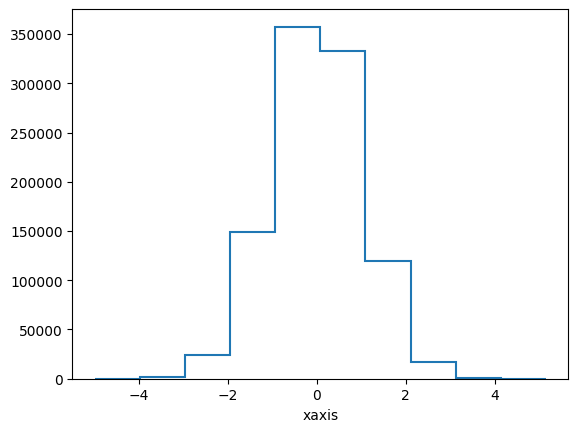

In [104]:
myfile["nested_directory/another_histogram;1"].to_hist().plot()

Lets now add a TTree to our file. We can do this in two ways. First, we can use the dict-like interphase as we have been doing so far, and pass a dictionary as the value. Each key of the dictionary will correspond to the name of the TBranch that forms part of the TTree, and the value for each key corresponds to the actual data.

In [ ]:
# One way to add branches
myfile["tree1"] = {
    "x": np.random.randint(0, 10, 1000000),
    "y": np.random.normal(0, 1, 1000000),
}

If you wanted to add more data to this TTree, you can use the `extend` method.

In [ ]:
myfile["tree1"].extend(
    {"x": np.random.randint(0, 10, 1000000), "y": np.random.normal(0, 1, 1000000)}
)
myfile["tree1"].extend(
    {"x": np.random.randint(0, 10, 1000000), "y": np.random.normal(0, 1, 1000000)}
)

Another way to add data to instantiate a TTree and store data in it is by using the `mktree` (i.e., "make tree") method. This way of adding data can be better, as it gives you more control over the type of each TBranch (notice that we didn't specify what type of data we put in the tree when we used the previous method; we left the computer to figure that out by itself!).

In [109]:
# Another way to add baskets
myfile.mktree("tree2", {"x": np.int32, "y": np.float64})
for _ in range(20):
    myfile["tree2"].extend(
        {"x": np.random.randint(0, 10, 1000000), "y": np.random.normal(0, 1, 1000000)}
    )

Once we have stored data in our TTree, we can check the number of baskets into which the data is divided.

In [110]:
# Each call to extend create a new basket in the `tree2` branch
myfile["tree2"].num_baskets

20

The list of data types that can be written to files can be found here: [link](https://uproot.readthedocs.io/en/latest/basic.html#writing-objects-to-a-file)

## Moving on

We now have some of the basic knowledge required to work with ROOT files using Uproot. We will now go on to apply what we have learned to explore and analyze some simulated data!